In [1]:
import numpy as np
import scipy as sp
import scipy.stats as sts
import pandas as pd
import geopandas as gpd

import pymc3 as pm

import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import time

np.random.seed(24) # 42

/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 88 from C header, got 96 from PyObject
  return f(*args, **kwds)
/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwd

# train data and dce hp mp:

In [2]:
pkl_file = open('train_df_sce.pkl', 'rb')
df = pickle.load(pkl_file)
pkl_file.close()

# pkl_file = open('cm_hp_trace_mu.pkl', 'rb')
# dce_hp_trace_mu = pickle.load(pkl_file)
# pkl_file.close()

pkl_file = open('cm_hp_mp_mu.pkl', 'rb')
cm_hp_mp_mu = pickle.load(pkl_file)
pkl_file.close()


In [3]:
cm_hp_mp_mu

{'η': array([1.13572121]), 'σ': array([0.9485678]), 'ℓ': array([3.55886543])}

In [4]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 442008 entries, 0 to 442007
Data columns (total 12 columns):
gid         442008 non-null int64
xcoord      442008 non-null float64
ycoord      442008 non-null float64
col         442008 non-null float64
row         442008 non-null float64
geometry    442008 non-null object
year        442008 non-null int64
gwno        442008 non-null float64
best        442008 non-null float64
log_best    442008 non-null float64
sce_mu      442008 non-null float64
sce_var     442008 non-null float64
dtypes: float64(9), int64(2), object(1)
memory usage: 43.8+ MB


# From log_bes to cm mu:
repertation, but this tim you have the mp to use for the prediction and don't need to estimate those.

In [5]:
df = df.sort_values(['gid','year'])

In [6]:
def get_X_new(step_size = 0.25, maxyear = 2017):
    step = step_size
    min_year = df['year'].min()
    max_year = maxyear #df['year'].max() # fordi du har 

    X_new = np.arange(min_year,max_year + step, step)[:,None]
    
    return(X_new)

In [7]:
# new try
def get_X_y_index():
    
    df_sort = df.sort_values(['gid','year'])
    
    X = np.array(df_sort['year'])[:,None]
    y = np.array(df_sort['log_best'])
    index = np.array(df_sort['gid'])
    
    return(X,y,index)

In [8]:
def get_gid_list():
    
    gid_list = []

    for i in df['gid'].unique():
        
        timeline  = df[df['gid'] == i]
        if np.count_nonzero(timeline['log_best']) >= 2:
            gid_list.append(i)
        
    gid_list = np.random.choice(gid_list, 100) # number of samples for hyper parameter estimates.
    
    return(gid_list)

In [9]:
def get_event_timelines():
    df_sub = df[df['gid'].isin(gid_list)].sort_values(['gid','year'])
    
    event_X = np.array(df_sub['year'])[:,None]
    event_y = np.array(df_sub['log_best'])
    event_index = np.array(df_sub['gid'])
    
    return(event_X, event_y, event_index)

In [10]:
X_new = get_X_new(1,2017)
X,y,index = get_X_y_index()
gid_list = get_gid_list()
X1,y1,index1 = get_event_timelines()

# Viz

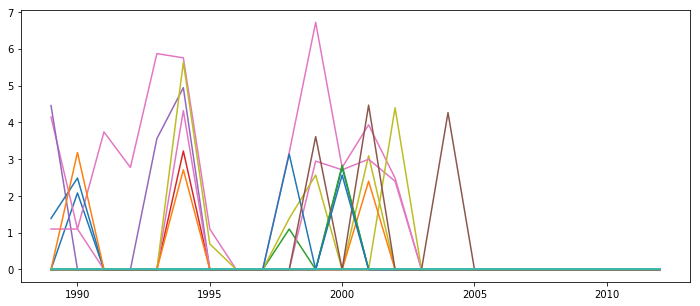

In [11]:
fig = plt.figure(figsize=(12,5))

for i, j in enumerate(np.unique(index)[0:100]):
    plt.plot(X[index == j], y[index==j])
    
plt.show()


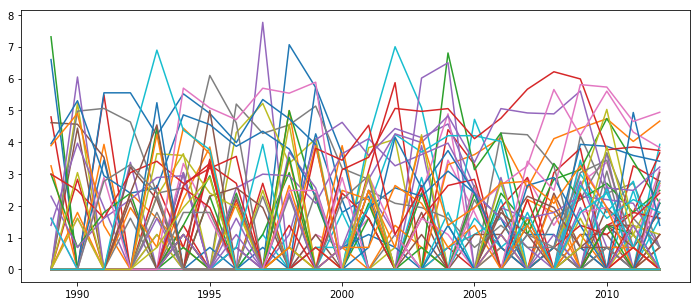

In [12]:
fig = plt.figure(figsize=(12,5))

for i, j in enumerate(np.unique(index1)[0:100]):
    plt.plot(X1[index1 == j], y1[index1==j])
    
plt.show()

# Estimation
### Define and illlustrate hyper-priors:

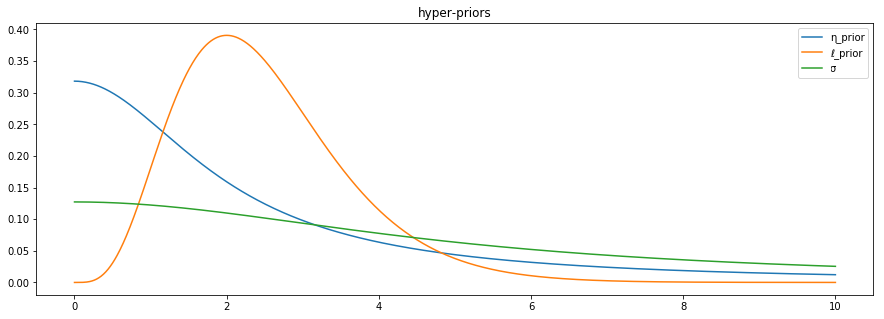

In [13]:
η_beta = 2
ℓ_beta = 2
ℓ_alpha = 5
σ_beta = 5

grid = np.linspace(0,10,1000)
priors = [
    ('η_prior', pm.HalfCauchy.dist(beta=η_beta)),
    ('ℓ_prior', pm.Gamma.dist(alpha=ℓ_alpha , beta=ℓ_beta )),
    ('σ', pm.HalfCauchy.dist(beta=σ_beta))]

plt.figure(figsize= [15,5])
plt.title('hyper-priors')


for i, prior in enumerate(priors):
    plt.plot(grid, np.exp(prior[1].logp(grid).eval()), label = prior[0])

plt.legend()
plt.show()

# from log_best to cm mu model:

In [14]:
# step0

time0 = time.time()

with pm.Model() as model:
    
    # trend
    ℓ = pm.Gamma("ℓ", alpha=ℓ_alpha , beta=ℓ_beta, shape = 1)
    η = pm.HalfCauchy("η", beta=η_beta, shape = 1)
    
    # noise model
    σ = pm.HalfCauchy("σ", beta=σ_beta, shape = 1)
    
    # Cov func.
    cov = η **2 * pm.gp.cov.ExpQuad(1, ℓ)
    
    # GP
    gp = pm.gp.Marginal(cov_func=cov)

    
    # sample: 
    for i, j in enumerate(np.unique(index1)):
        
#         mean = pm.gp.mean.Constant(np.mean(y[index == j]))
                
        y_ = gp.marginal_likelihood("y" + str(i) + "_", X=X1[index1 == j], y=y1[index1 == j], noise= σ)
        

/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


In [15]:
cm_hp_mp_mu

{'η': array([1.13572121]), 'σ': array([0.9485678]), 'ℓ': array([3.55886543])}

# All timelines:

Run it teo turns due to memory-leak and not enough ram...

# 1)

In [16]:
mp=cm_hp_mp_mu

time_0 = time.time()

mu_list = []
var_list = []

print('Started\n')

for i, j in enumerate(np.unique(index)[0:10000]):
    
    mu, var = gp.predict(X_new, point=mp, given = {'gp' : gp, 'X' : X[index == j], 'y' : y[index == j], 'noise' : σ },diag=True)
    
    mu_list.append(mu)
    var_list.append(var)
    
    if str(i)[-2:] == '00':
        print('{}/{}'.format(i,np.unique(index).shape[0]), end = '-')

print('\nEnded\n')
    
    
time_1 = time.time()

time_step1 = (time_1 - time_0)/60

print('total {} min'.format(time_step1))

Started



/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future 

100/18417-200/18417-300/18417-400/18417-500/18417-600/18417-700/18417-800/18417-900/18417-1000/18417-1100/18417-1200/18417-1300/18417-1400/18417-1500/18417-1600/18417-1700/18417-1800/18417-1900/18417-2000/18417-2100/18417-2200/18417-2300/18417-2400/18417-2500/18417-2600/18417-2700/18417-2800/18417-2900/18417-3000/18417-3100/18417-3200/18417-3300/18417-3400/18417-3500/18417-3600/18417-3700/18417-3800/18417-3900/18417-4000/18417-4100/18417-4200/18417-4300/18417-4400/18417-4500/18417-4600/18417-4700/18417-4800/18417-4900/18417-5000/18417-5100/18417-5200/18417-5300/18417-5400/18417-5500/18417-5600/18417-5700/18417-5800/18417-5900/18417-6000/18417-6100/18417-6200/18417-6300/18417-6400/18417-6500/18417-6600/18417-6700/18417-6800/18417-6900/18417-7000/18417-7100/18417-7200/18417-7300/18417-7400/18417-7500/18417-7600/18417-7700/18417-7800/18417-7900/18417-8000/18417-8100/18417-8200/18417-8300/18417-8400/18417-8500/18417-8600/18417-8700/18417-8800/18417-8900/18417-9000/18417-9100/18417-9200/184

# PICKLE MU_LIST and VAR_LIST

In [17]:
file_path = 'cm_mu_list_0_10000.pkl'.format(i)
output = open(file_path, 'wb') # still not working right!!
pickle.dump(mu_list, output)
output.close()

In [18]:
file_path = 'cm_var_list_0_10000.pkl'.format(i)
output = open(file_path, 'wb') # still not working right!!
pickle.dump(var_list, output)
output.close()

In [19]:
len(mu_list)

10000

In [20]:
len(var_list)

10000

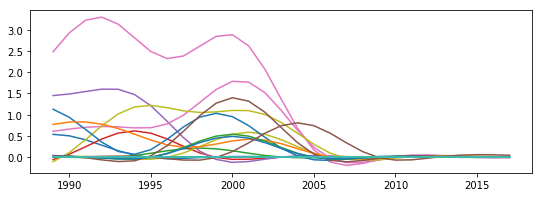

In [21]:
plt.figure(figsize = [9,3])

for i in np.arange(0,100):
    plt.plot(X_new,mu_list[i])
    
plt.show()

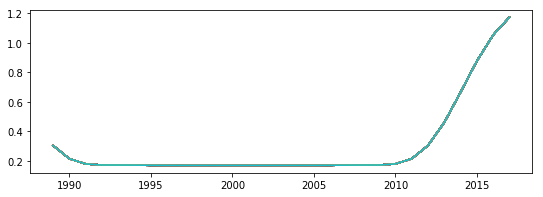

In [22]:
plt.figure(figsize = [9,3])

for i in np.arange(0,100):
    plt.plot(X_new,var_list[i])
    
plt.show()

# Pickle test:

In [23]:
pkl_file = open('cm_mu_list_0_10000.pkl', 'rb')
pickle_test_mu_list = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open('cm_var_list_0_10000.pkl', 'rb')
pickle_test_var_list = pickle.load(pkl_file)
pkl_file.close()

In [24]:
len(pickle_test_mu_list)

10000

In [25]:
len(pickle_test_var_list)

10000

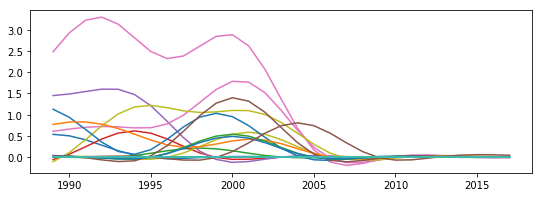

In [26]:
plt.figure(figsize = [9,3])

for i in np.arange(0,100):
    plt.plot(X_new,pickle_test_mu_list[i])
    
plt.show()

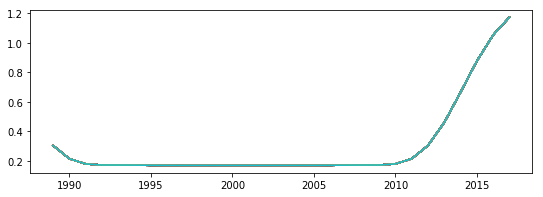

In [27]:
plt.figure(figsize = [9,3])

for i in np.arange(0,100):
    plt.plot(X_new,pickle_test_var_list[i])
    
plt.show()

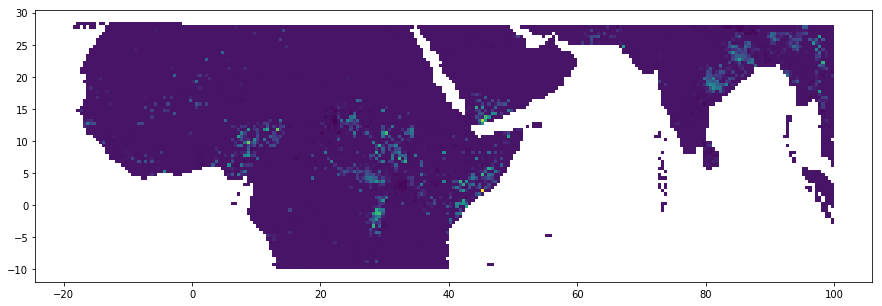

In [28]:
cm_mu_train_years = np.array(pickle_test_mu_list)[0:10000,0:24].flatten() # no new x years
# you just use the original df when you want to add extrapolated years
df_sub_0_10k = df.sort_values(['gid','year'])[0:240000].copy()
df_sub_0_10k['cm_mu'] = cm_mu_train_years

df_sub_0_10k[df_sub_0_10k['year']==2012].plot(column = 'cm_mu', figsize=(15, 15))
plt.show()

# 2)

In [16]:
mp=cm_hp_mp_mu

time_0 = time.time()

mu_list_10k = []
var_list_10k = []

print('Started\n')

for i, j in enumerate(np.unique(index)[10000:]):
    
    mu, var = gp.predict(X_new, point=mp, given = {'gp' : gp, 'X' : X[index == j], 'y' : y[index == j], 'noise' : σ },diag=True)
    
    mu_list_10k.append(mu)
    var_list_10k.append(var)
    
    if str(i)[-2:] == '00':
        print('{}/{}'.format(i,np.unique(index).shape[0]), end = '-')

print('\nEnded\n')
    
    
time_1 = time.time()

time_step1 = (time_1 - time_0)/60

print('total {} min'.format(time_step1))

Started



/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future 

100/18417-200/18417-300/18417-400/18417-500/18417-600/18417-700/18417-800/18417-900/18417-1000/18417-1100/18417-1200/18417-1300/18417-1400/18417-1500/18417-1600/18417-1700/18417-1800/18417-1900/18417-2000/18417-2100/18417-2200/18417-2300/18417-2400/18417-2500/18417-2600/18417-2700/18417-2800/18417-2900/18417-3000/18417-3100/18417-3200/18417-3300/18417-3400/18417-3500/18417-3600/18417-3700/18417-3800/18417-3900/18417-4000/18417-4100/18417-4200/18417-4300/18417-4400/18417-4500/18417-4600/18417-4700/18417-4800/18417-4900/18417-5000/18417-5100/18417-5200/18417-5300/18417-5400/18417-5500/18417-5600/18417-5700/18417-5800/18417-5900/18417-6000/18417-6100/18417-6200/18417-6300/18417-6400/18417-6500/18417-6600/18417-6700/18417-6800/18417-6900/18417-7000/18417-7100/18417-7200/18417-7300/18417-7400/18417-7500/18417-7600/18417-7700/18417-7800/18417-7900/18417-8000/18417-8100/18417-8200/18417-8300/18417-8400/18417-
Ended

total 1066.334114853541 min


# PICKLE!

In [17]:
file_path = 'cm_mu_list_10000_18417.pkl'.format(i)
output = open(file_path, 'wb') # still not working right!!
pickle.dump(mu_list_10k, output)
output.close()

In [18]:
file_path = 'cm_var_list_10000_18417.pkl'.format(i)
output = open(file_path, 'wb') # still not working right!!
pickle.dump(var_list_10k, output)
output.close()

# Check

In [19]:
len(mu_list_10k)

8417

In [20]:
len(var_list_10k)

8417

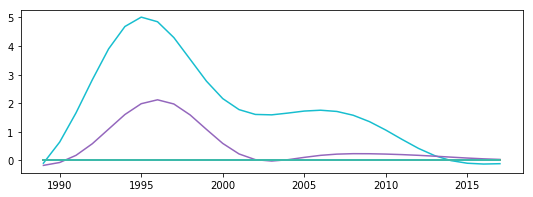

In [21]:
plt.figure(figsize = [9,3])

for i in np.arange(0,100):
    plt.plot(X_new,mu_list_10k[i])
    
plt.show()

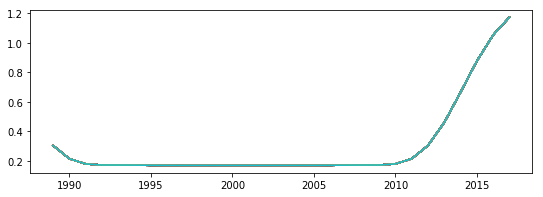

In [22]:
plt.figure(figsize = [9,3])

for i in np.arange(0,100):
    plt.plot(X_new,var_list_10k[i])
    
plt.show()

In [23]:
cm_mu_train_years = np.array(mu_list_10k)[:,0:24].flatten()


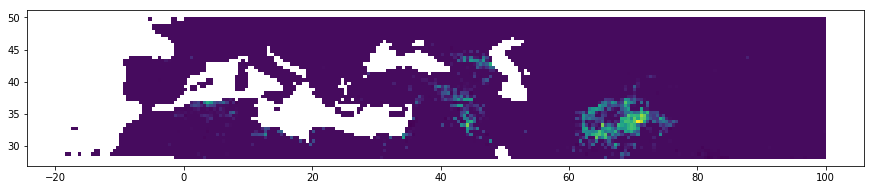

In [24]:
cm_mu_train_years = np.array(mu_list_10k)[:,0:24].flatten()
# you just use the original df when you want to add extrapolated years


df_sub_10k_18k = df.sort_values(['gid','year'])[240000:240000+202008].copy() # cm_mu_train_years.shape
df_sub_10k_18k['cm_mu'] = cm_mu_train_years

df_sub_10k_18k[df_sub_10k_18k['year']==2012].plot(column = 'cm_mu', figsize=(15, 15))
plt.show()

# pickle test:

In [25]:
pkl_file = open('cm_mu_list_10000_18417.pkl', 'rb')
pickle_test_mu_list_10k = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open('cm_var_list_10000_18417.pkl', 'rb')
pickle_test_var_list_10k = pickle.load(pkl_file)
pkl_file.close()

In [26]:
len(pickle_test_mu_list_10k)

8417

In [27]:
len(pickle_test_var_list_10k)

8417

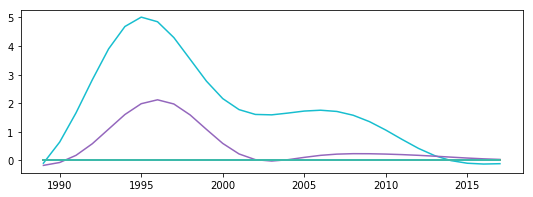

In [28]:
plt.figure(figsize = [9,3])

for i in np.arange(0,100):
    plt.plot(X_new,pickle_test_mu_list_10k[i])
    
plt.show()

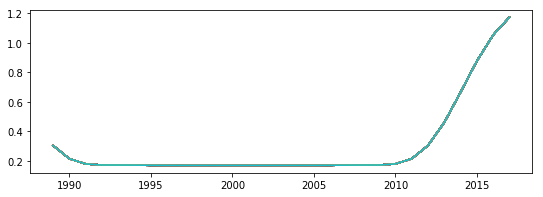

In [29]:
plt.figure(figsize = [9,3])

for i in np.arange(0,100):
    plt.plot(X_new,pickle_test_var_list_10k[i])
    
plt.show()

In [30]:
PT_cm_mu_train_years = np.array(mu_list_10k)[:,0:24].flatten()


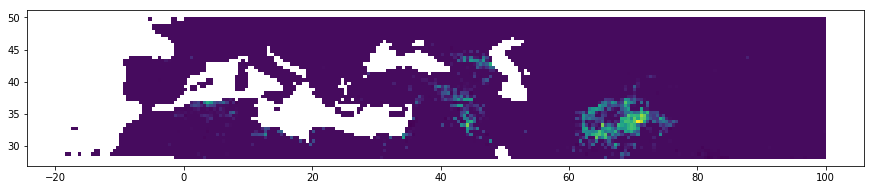

In [33]:
PT_cm_mu_train_years = np.array(pickle_test_mu_list_10k)[:,0:24].flatten()
# you just use the original df when you want to add extrapolated years


PT_df_sub_10k_18k = df.sort_values(['gid','year'])[240000:240000+202008].copy() # cm_mu_train_years.shape
PT_df_sub_10k_18k['cm_mu'] = PT_cm_mu_train_years

PT_df_sub_10k_18k[PT_df_sub_10k_18k['year']==2012].plot(column = 'cm_mu', figsize=(15, 15))
plt.show()

In [34]:
ba_mu_10k = mu_list_10k
ba_mu_10k = var_list_10k

# Togheter

In [35]:
pkl_file = open('cm_mu_list_0_10000.pkl', 'rb')
mu_list = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open('cm_var_list_0_10000.pkl', 'rb')
var_list = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open('cm_mu_list_10000_18417.pkl', 'rb')
mu_list_10k = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open('cm_var_list_10000_18417.pkl', 'rb')
var_list_10k = pickle.load(pkl_file)
pkl_file.close()

In [36]:
mu_list_full = mu_list+mu_list_10k
var_list_full = var_list+var_list_10k

print(np.array(mu_list_full).shape)
print(np.array(var_list_full).shape)

(18417, 29)
(18417, 29)


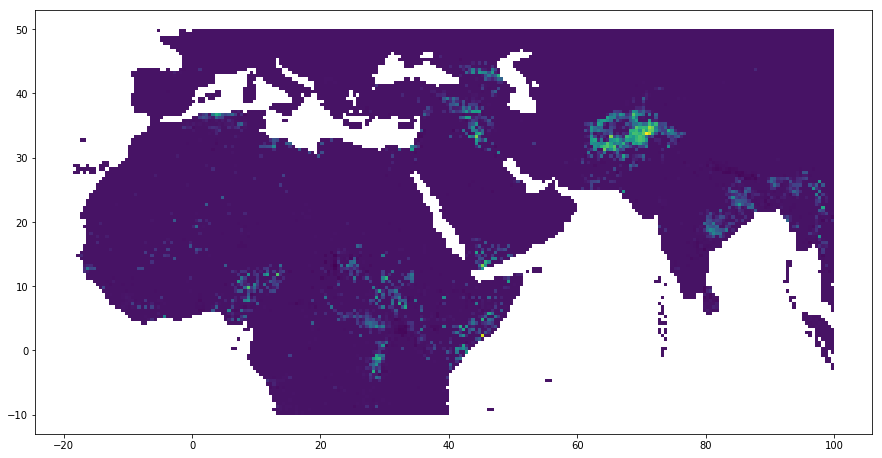

In [37]:
cm_mu_train_years_full = np.array(mu_list_full)[:,0:24].flatten()
# you just use the original df when you want to add extrapolated years


df_sorted = df.sort_values(['gid','year']).copy() # dce_mu_train_years.shape
df_sorted['cm_mu'] = cm_mu_train_years_full

df_sorted[df_sorted['year']==2012].plot(column = 'cm_mu', figsize=(15, 15))
plt.show()

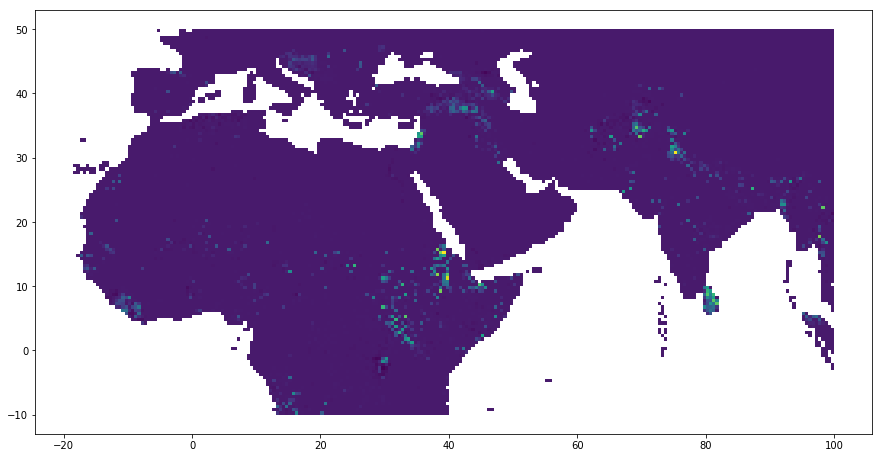

In [38]:
cm_mu_train_years_full = np.array(mu_list_full)[:,0:24].flatten()
# you just use the original df when you want to add extrapolated years


df_sorted = df.sort_values(['gid','year']).copy() # dce_mu_train_years.shape
df_sorted['cm_mu'] = cm_mu_train_years_full

df_sorted[df_sorted['year']==1989].plot(column = 'cm_mu', figsize=(15, 15))
plt.show()

# Pickle full lists:

In [39]:
file_path = 'cm_mu_list_full.pkl'.format(i)
output = open(file_path, 'wb') # still not working right!!
pickle.dump(mu_list_full, output)
output.close()

In [40]:
file_path = 'cm_var_list_full.pkl'.format(i)
output = open(file_path, 'wb') # still not working right!!
pickle.dump(var_list_full, output)
output.close()

# Last pickle test:

In [91]:
pkl_file = open('cm_mu_list_full.pkl', 'rb')
PT_mu_list_full = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open('cm_var_list_full.pkl', 'rb')
PT_var_list_full = pickle.load(pkl_file)
pkl_file.close()


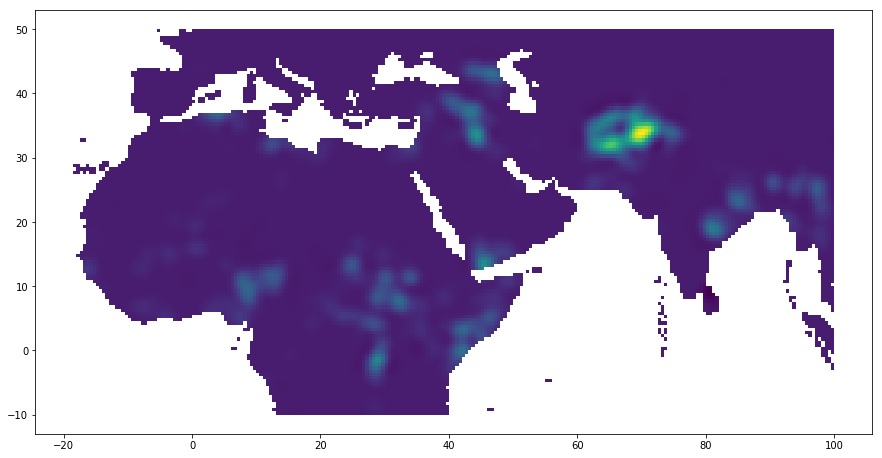

In [93]:
PT_cm_mu_train_years_full = np.array(PT_mu_list_full)[:,0:24].flatten()
# you just use the original df when you want to add extrapolated years


df_sorted = df.sort_values(['gid','year']).copy() # cm_mu_train_years.shape
df_sorted['cm_mu'] = PT_cm_mu_train_years_full

df_sorted[df_sorted['year']==2012].plot(column = 'dce_mu', figsize=(15, 15))
plt.show()

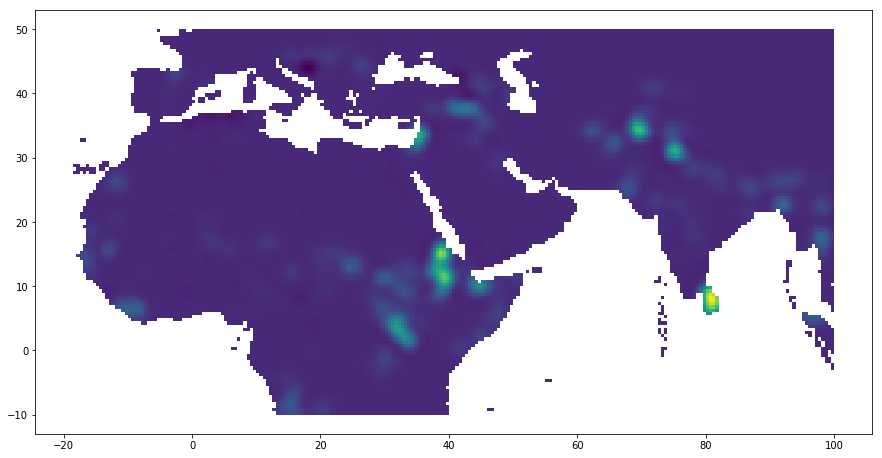

In [92]:
PT_cm_mu_train_years_full = np.array(PT_mu_list_full)[:,0:24].flatten()
# you just use the original df when you want to add extrapolated years


df_sorted = df.sort_values(['gid','year']).copy() # cm_mu_train_years.shape
df_sorted['cm_mu'] = PT_cm_mu_train_years_full

df_sorted[df_sorted['year']==1989].plot(column = 'dce_mu', figsize=(15, 15))
plt.show()